# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    classification_report, confusion_matrix, roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# 2. Load Dataset

In [2]:
df = pd.read_csv('../../data/stroke.csv')

# 3. Data Cleaning

In [3]:
df = df.drop(columns=['id', 'Residence_type', 'gender'], errors='ignore')
df = df.drop_duplicates().dropna()

# 4. Merge Work Types and Encode Married

In [4]:
df['work_type'] = df['work_type'].replace({
    'children': 'Child_Neverwork',
    'Never_worked': 'Child_Neverwork'
})
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})

# 5. Feature Engineering

In [5]:
df['age_glucose_interaction'] = df['age'] * df['avg_glucose_level']
df['age_bmi_interaction'] = df['age'] * df['bmi']
df['high_risk'] = ((df['hypertension'] == 1) | (df['heart_disease'] == 1)).astype(int)

# 6. Split data

In [6]:
RANDOM_STATE = 42
X = df.drop(columns=['stroke'])
y = df['stroke']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_STATE
)

# 7. Preprocessor

In [7]:
numeric_cols = ['age', 'avg_glucose_level', 'bmi', 'age_glucose_interaction', 'age_bmi_interaction']
binary_cols = ['high_risk', 'hypertension', 'heart_disease', 'ever_married']
categorical_cols = ['work_type', 'smoking_status']

In [8]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('bin', 'passthrough', binary_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# 8. Build SVM pipeline

In [9]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ('svm', SVC(
        kernel='rbf',
        C=1.0,
        gamma=0.001,
        class_weight='balanced',
        probability=True,
        random_state=RANDOM_STATE
    ))
])

# 9. Fit pipeline

In [10]:
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# 10. Evaluate

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix, roc_curve
import numpy as np

def evaluate_split(y_true, y_proba, threshold=0.5, name="Split"):
    y_pred = (y_proba >= threshold).astype(int)
    roc_auc = roc_auc_score(y_true, y_proba)
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(rec, prec)
    print(f"\n=== {name} ===")
    print(f"Threshold={threshold:.2f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title(f"Confusion Matrix - {name} (thr={threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [12]:
def plot_prob_distributions(y_true, y_proba, threshold=0.5):
    no_stroke_probs = y_proba[y_true == 0]
    stroke_probs = y_proba[y_true == 1]

    no_stroke_pred_below_thr = no_stroke_probs[no_stroke_probs < threshold]
    no_stroke_pred_above_thr = no_stroke_probs[no_stroke_probs >= threshold]
    stroke_pred_below_thr = stroke_probs[stroke_probs < threshold]
    stroke_pred_above_thr = stroke_probs[stroke_probs >= threshold]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    bins = np.linspace(0, 1, 30)

    sns.histplot(no_stroke_pred_below_thr, bins=bins, color='blue', label='TN', ax=axes[0], alpha=0.7)
    sns.histplot(no_stroke_pred_above_thr, bins=bins, color='red', label='FP', ax=axes[0], alpha=0.7)
    axes[0].axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    axes[0].set_xlim(0, 1)
    axes[0].set_title('Predicted Probabilities for True No Stroke Cases')
    axes[0].set_xlabel('Predicted Probability of Stroke')
    axes[0].set_ylabel('Count')
    axes[0].legend()

    sns.histplot(stroke_pred_below_thr, bins=bins, color='red', label='FN', ax=axes[1], alpha=0.7)
    sns.histplot(stroke_pred_above_thr, bins=bins, color='blue', label='TP', ax=axes[1], alpha=0.7)
    axes[1].axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    axes[1].set_xlim(0, 1)
    axes[1].set_title('Predicted Probabilities for True Stroke Cases')
    axes[1].set_xlabel('Predicted Probability of Stroke')
    axes[1].set_ylabel('Count')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


In [13]:
val_proba = pipe.predict_proba(X_val)[:,1]
test_proba = pipe.predict_proba(X_test)[:,1]

Validation:

=== Validation ===
Threshold=0.30, ROC-AUC=0.8649, PR-AUC=0.1524
              precision    recall  f1-score   support

           0     0.9979    0.6175    0.7629       753
           1     0.1000    0.9697    0.1813        33

    accuracy                         0.6323       786
   macro avg     0.5489    0.7936    0.4721       786
weighted avg     0.9602    0.6323    0.7385       786



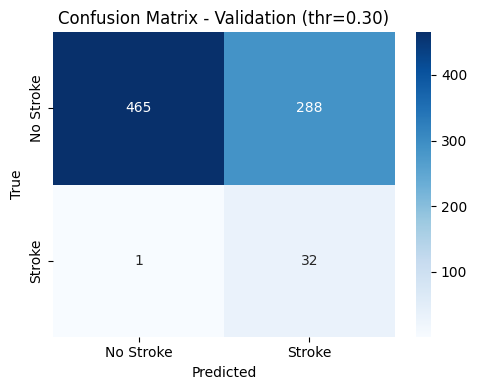

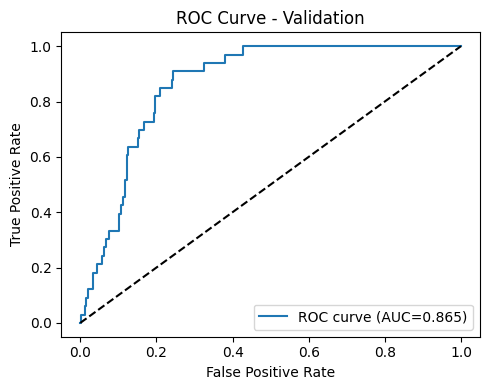

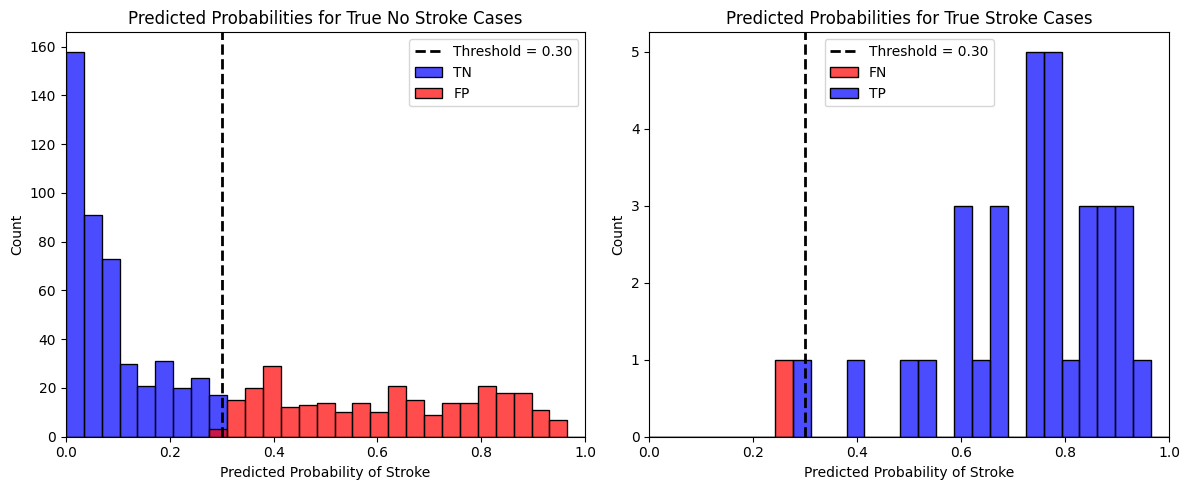

In [14]:

print("Validation:")
evaluate_split(y_val, val_proba, threshold=0.3, name="Validation")
plot_prob_distributions(y_val, val_proba, threshold=0.3)

Test:

=== Test ===
Threshold=0.30, ROC-AUC=0.8140, PR-AUC=0.2238
              precision    recall  f1-score   support

           0     0.9865    0.6223    0.7632       940
           1     0.0874    0.8095    0.1578        42

    accuracy                         0.6303       982
   macro avg     0.5370    0.7159    0.4605       982
weighted avg     0.9481    0.6303    0.7373       982



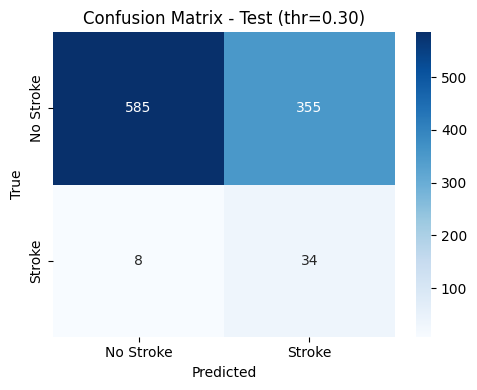

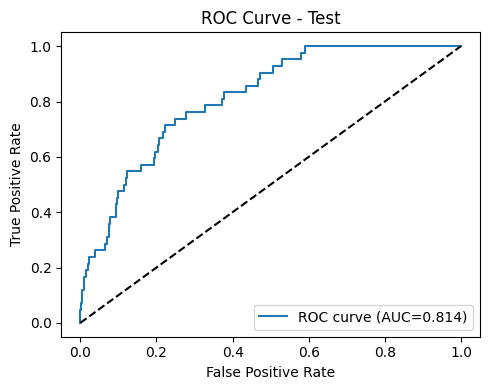

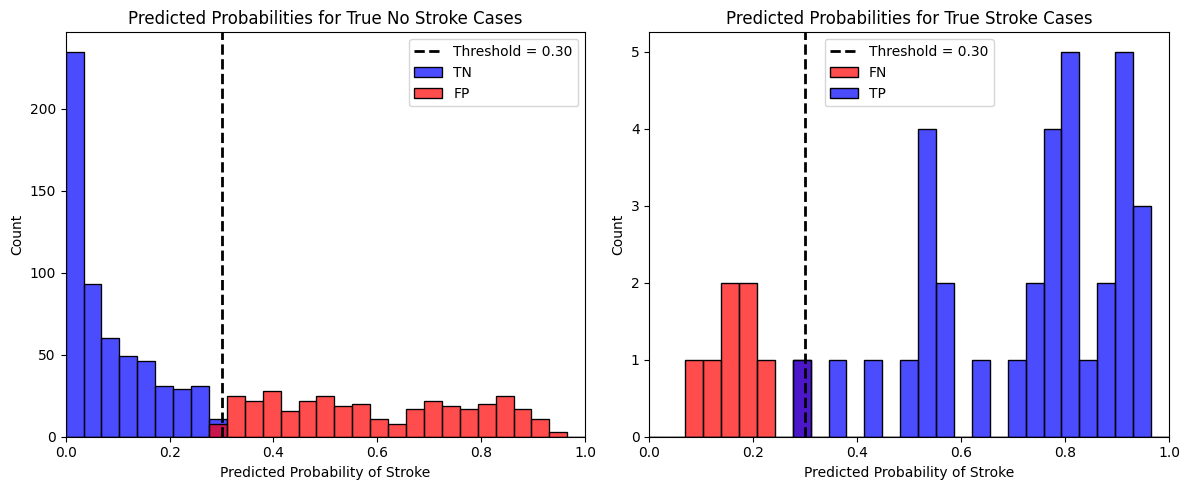

In [15]:
print("Test:")
evaluate_split(y_test, test_proba, threshold=0.3, name="Test")
plot_prob_distributions(y_test, test_proba, threshold=0.3)

# 11. Final Model Evaluation (Training on Combined Data)

Final Test Set Evaluation:

=== Test ===
Threshold=0.30, ROC-AUC=0.8146, PR-AUC=0.2387
              precision    recall  f1-score   support

           0     0.9851    0.6330    0.7707       940
           1     0.0873    0.7857    0.1571        42

    accuracy                         0.6395       982
   macro avg     0.5362    0.7093    0.4639       982
weighted avg     0.9467    0.6395    0.7445       982



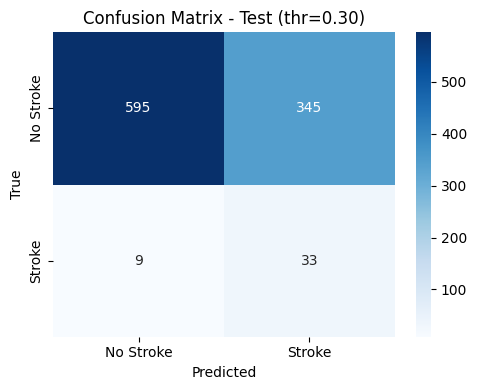

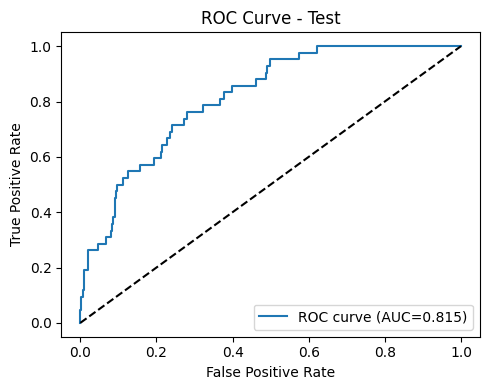

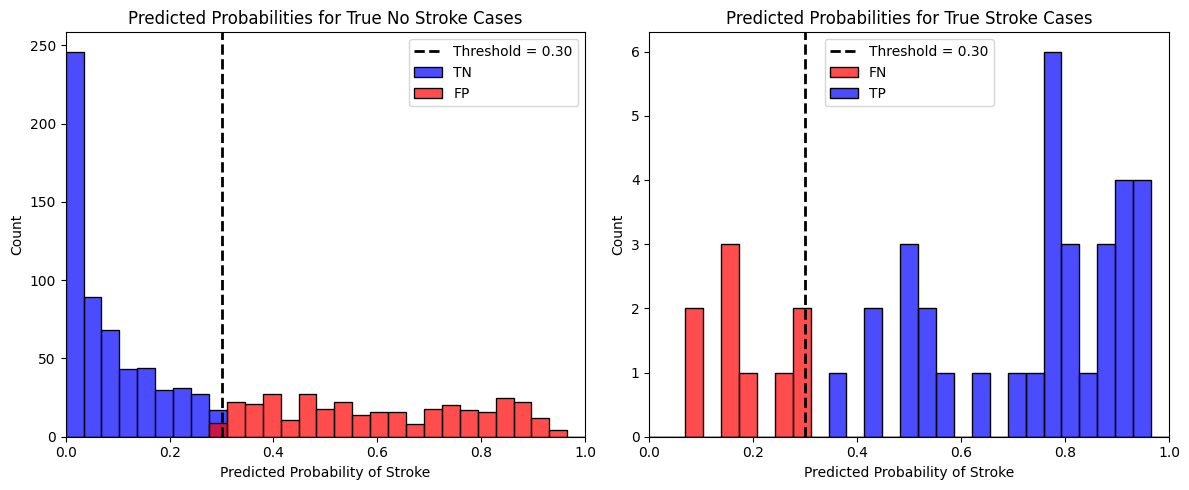

In [16]:
# Combine train and validation sets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Retrain the pipeline on combined data
pipe.fit(X_train_full, y_train_full)

# Get predictions on test set
test_proba = pipe.predict_proba(X_test)[:, 1]

# Evaluate on test set
print('Final Test Set Evaluation:')
evaluate_split(y_test, test_proba, threshold=0.3, name="Test")
plot_prob_distributions(y_test, test_proba, threshold=0.3)

# 12. Save model

In [17]:
import cloudpickle

with open("../models/stroke_rate_svm.pkl", "wb") as f:
    cloudpickle.dump(pipe, f)

In [18]:
with open("../models/stroke_rate_svm.pkl", "rb") as f:
    loaded_model = cloudpickle.load(f)

Loaded Model Test Set Evaluation:

=== Test (Loaded Model) ===
Threshold=0.30, ROC-AUC=0.8146, PR-AUC=0.2387
              precision    recall  f1-score   support

           0     0.9851    0.6330    0.7707       940
           1     0.0873    0.7857    0.1571        42

    accuracy                         0.6395       982
   macro avg     0.5362    0.7093    0.4639       982
weighted avg     0.9467    0.6395    0.7445       982



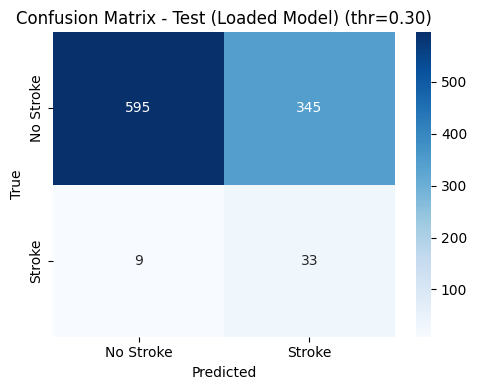

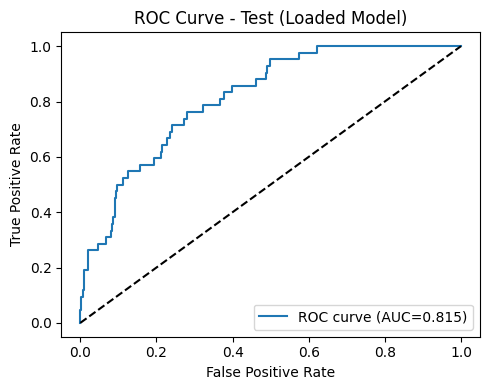

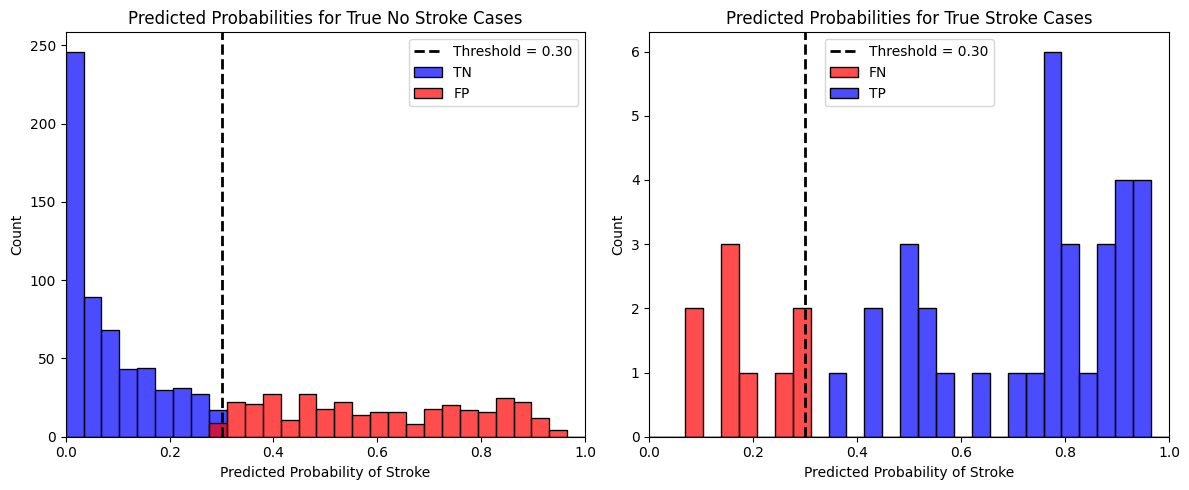


Verification of Model Loading:
Maximum difference in predictions: 0.0000000000
Models are identical:


In [19]:
loaded_test_proba = loaded_model.predict_proba(X_test)[:, 1]

# Evaluate on test set
print('Loaded Model Test Set Evaluation:')
evaluate_split(y_test, loaded_test_proba, threshold=0.3, name="Test (Loaded Model)")
plot_prob_distributions(y_test, loaded_test_proba, threshold=0.3)

# Verify that predictions match with original model
original_predictions = test_proba
loaded_predictions = loaded_test_proba

print("\nVerification of Model Loading:")
print(f"Maximum difference in predictions: {np.max(np.abs(original_predictions - loaded_predictions)):.10f}")
print("Models are identical:" if np.allclose(original_predictions, loaded_predictions) else "Warning: Models differ!")

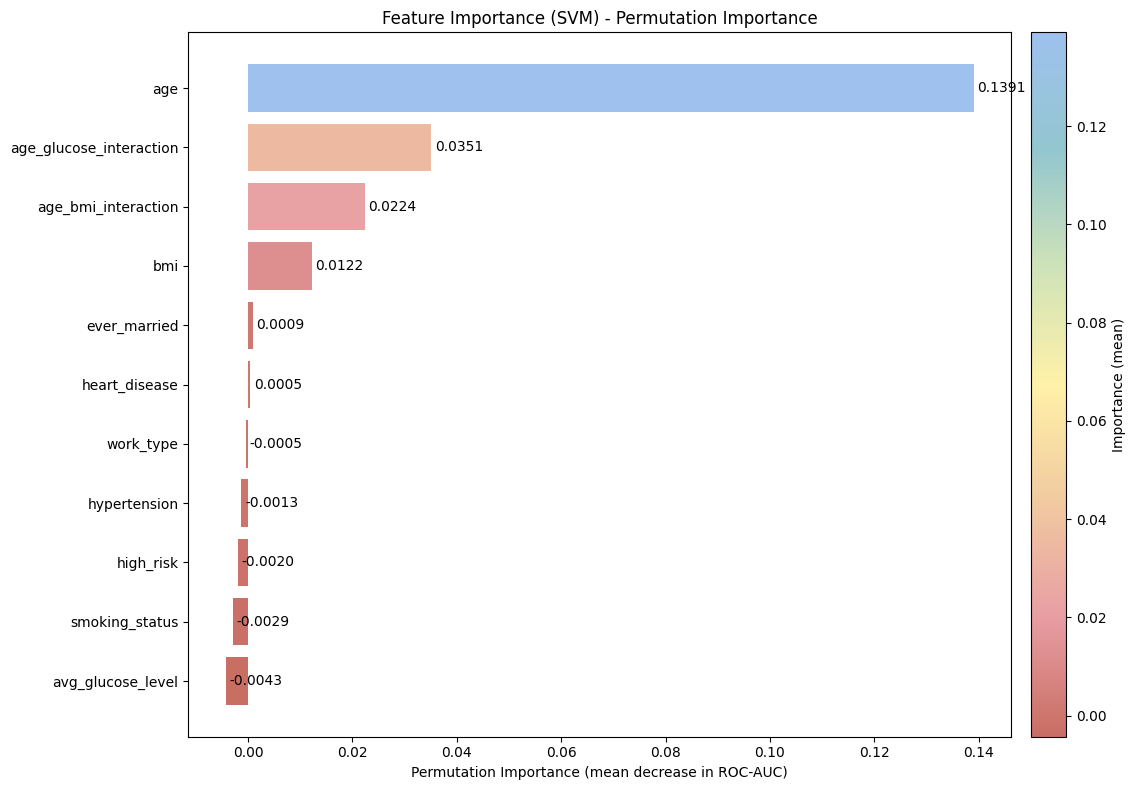

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

# Compute permutation importance on validation set (works for non-linear SVM)
feature_names = X_train.columns
result = permutation_importance(pipe, X_val, y_val, n_repeats=30, random_state=42, n_jobs=-1, scoring='roc_auc')
importances = result.importances_mean

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance for plotting (ascending so largest at top)
feature_importance = feature_importance.sort_values('Importance', ascending=True)

# Map importances to a pastel warm-to-cool palette
norm = plt.Normalize(vmin=feature_importance['Importance'].min(), vmax=feature_importance['Importance'].max())
sun_colors = ['#c96e63', '#e79da3', '#f1caa0', '#fff1a8', '#cfe3b8', '#93c6cf', '#9ec1ee']
cmap = LinearSegmentedColormap.from_list('sunlight', sun_colors)
colors = [cmap(norm(v)) for v in feature_importance['Importance']]

# Plot horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
plt.xlabel('Permutation Importance (mean decrease in ROC-AUC)')
plt.title('Feature Importance (SVM) - Permutation Importance')

# Colorbar indicating magnitude
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(feature_importance['Importance'])
ax = plt.gca()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Importance (mean)')

# Add value labels on the bars
for bar, val in zip(bars, feature_importance['Importance']):
    plt.text(bar.get_width() + max(feature_importance['Importance']) * 0.005, bar.get_y() + bar.get_height()/2, f'{val:.4f}', ha='left', va='center')

plt.tight_layout()
plt.show()